Notebook for training BERT classifier

## Setup
- Copy into the notebook the training.csv and testing.csv data


## Load Data
- Set DROP_SOCIAL_PRESSURE to True if you are removing those labels

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

path_to_training = 'training.csv'
path_to_testing  = 'testing.csv'
DROP_SOCIAL_PRESSURE = True # If you want to remove the social and pressure tags
concat=True
"""This concatinates the training.csv/testing.csv training.csv was annotated by
phd students and testing.csv was annotated by the project team. I believe we
annotated different data but I need to double check"""
drop_dups=True # Drops duplicates. not 100% this is necessary
test_size=0.2 # If concaenating u can choose sklearn test split with this
verbose = True

def import_data(path_to_training,
                path_to_testing,
                drop_social_pressure=None,
                concat=None,
                verbose=None,
                drop_dups=None,
                test_size=0.2):

  if concat:
    df = pd.concat([pd.read_csv(path_to_training),
                    pd.read_csv(path_to_testing)])
    train_df, test_df = train_test_split(df, test_size=test_size,
                                         shuffle=True, random_state=42
                                         )

  else:
    train_df = pd.read_csv(path_to_training)
    test_df = pd.read_csv(path_to_testing)

  if DROP_SOCIAL_PRESSURE:
    train_df=train_df.drop(columns=['6-SOCIAL', '7-PRESSURE'])
    test_df = test_df.drop(columns=['6-SOCIAL', '7-PRESSURE'])

  if drop_dups:
    train_df = train_df.drop_duplicates()
    test_df = test_df.drop_duplicates()

  label_columns = train_df.columns[1:].tolist()

  if verbose:
    print(f'Num Training {len(train_df)}')
    print(f'Num Evaluation {len(test_df)}')

  return train_df, test_df, label_columns

train_df, test_df, label_columns = import_data(
    path_to_training, path_to_testing, DROP_SOCIAL_PRESSURE, concat, verbose)


Num Training 6917
Num Evaluation 1730


In [8]:
train_df.head()

,text,1-RAPPORT,2-NEGOTIATE,3-EMOTION,4-LOGIC,5-AUTHORITY,8-NO-PERSUASION
1737,"I've some friends in Texas, and they were send...",1,0,0,0,0,0
2036,Thank you for your consideration.,1,0,0,0,0,0
2669,Well refugees are fleeing Syria left and right...,0,0,1,0,0,0
2628,Do you have any desire to give to this Save th...,0,1,0,0,0,0
6433,"Since they're run completely on donations, do...",0,1,0,0,0,0


## Visualise Tag Distribution

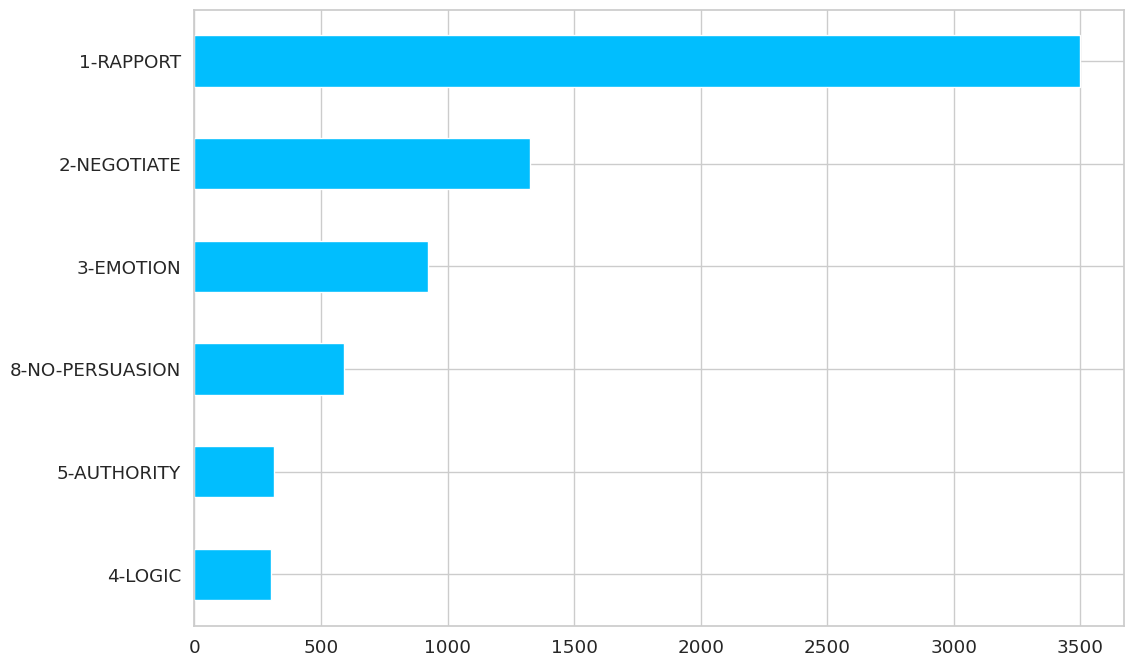

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

train_df[label_columns].sum().sort_values().plot(kind="barh");

## Init BERT Stuff
1. Set mex token count by visualising token distrubtions

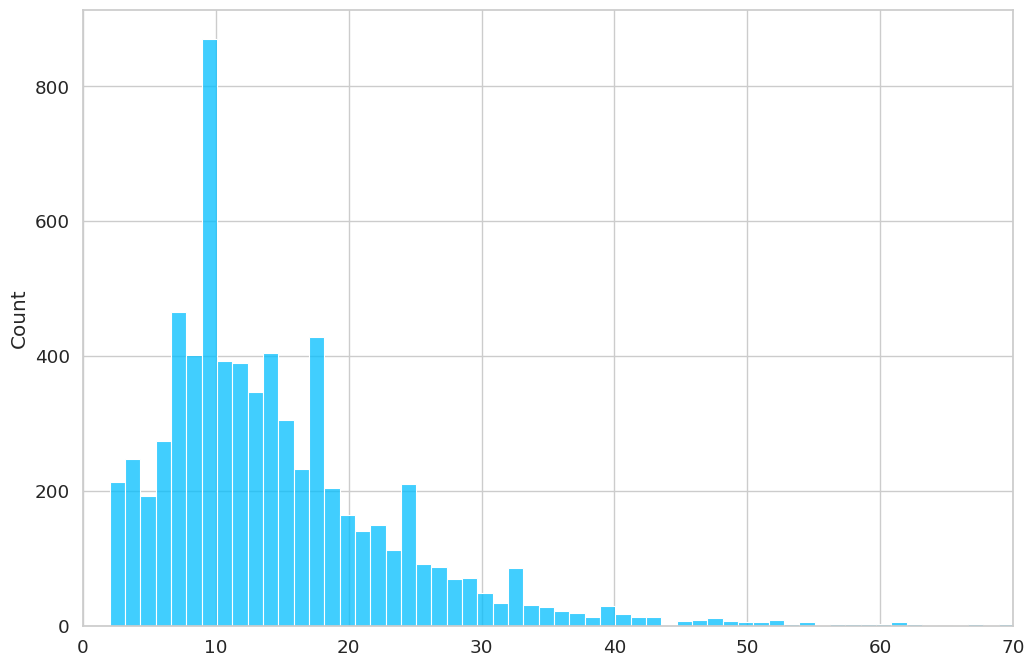

In [10]:
from transformers import BertTokenizer, BertModel

BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

def visualise_tokencounts(df, column_name, max_tokens):

    token_counts = []

    for _, row in df.iterrows():

        token_count = len(tokenizer.encode(
        row[column_name],
        max_length=max_tokens+50,
        truncation=True

      ))

        token_counts.append(token_count)
    sns.histplot(token_counts)
    plt.xlim([0, max_tokens]);

visualise_tokencounts(train_df, 'text', 70)

In [11]:
MAX_TOKEN_COUNT = 60 # Set Max token. Larger token count will lead to more padding for shorter sequences

## Build DataLoaders

In [12]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch

class PersuasionStrategyDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = MAX_TOKEN_COUNT
        ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        self.LABEL_COLUMNS = data.columns.tolist()[1:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):

        data_row = self.data.iloc[index]
        comment_text = data_row.text
        labels = data_row[self.LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(
          comment_text,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          comment_text=comment_text,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=torch.FloatTensor(labels)
        )

## Add WeightedSampler

In [13]:
from collections import Counter

def build_sampler(training_dataset):
  labels = [torch.argmax(label['labels']).item() for label in training_dataset]  # Assuming your dataset returns (input_vector, label) pairs
  class_distribution = Counter(labels)

  # Calculate weights for each sample
  class_weights = {class_label: len(training_dataset) / (len(class_distribution) * class_count) for class_label, class_count in class_distribution.items()}
  weights = [class_weights[label] for label in labels]

  # Convert weights to tensor
  weights_tensor = torch.tensor(weights, dtype=torch.float)

  # Create a sampler to balance the dataset during training
  sampler = WeightedRandomSampler(weights_tensor, len(weights_tensor))
  return sampler

In [14]:
sampler=True # Choose to use weighted sampler

training_dataset = PersuasionStrategyDataset(
    train_df,
    tokenizer
)

if sampler:
  print('Building Sampler')
  sampler = build_sampler(training_dataset)

training_dataloader = DataLoader(
    training_dataset,
    batch_size=32,
    sampler=sampler
)

## Model Architecture

In [15]:
import torch.nn as nn

# Load pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME)

# Define your classification model
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

## Set hyperparameters

In [16]:
from torch.optim import lr_scheduler
from tqdm.auto import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 5
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multilabel classification

model = BertClassifier(bert_model, len(label_columns))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

## TRAIN!

In [18]:
def train(model, training_dataloader, num_epochs):

  avg_loss = 0
  model.train()

  with tqdm(range(num_epochs), desc='Average Epoch Loss: ') as t:
    for epoch in range(num_epochs):
        epoch_loss = []

        with tqdm(range(len(training_dataloader)), desc='Loss: 0') as t2:
          for batch_num, batch in enumerate(training_dataloader):

              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['labels'].to(device)

              optimizer.zero_grad()

              outputs = model(input_ids, attention_mask)

              loss = criterion(outputs, labels.float())
              epoch_loss.append(loss.item())
              loss.backward()
              optimizer.step()

              t2.set_description(
                  f'Loss: {round(sum(epoch_loss)/len(epoch_loss),4)}')
              t2.update()

        t.set_description(
        f'Average Epoch Loss: {round(sum(epoch_loss)/len(epoch_loss),4)}')
        t.update()

  return avg_loss, model

In [19]:
avg_loss, model = train(model, training_dataloader, num_epochs)

Average Epoch Loss:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/217 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/217 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/217 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/217 [00:00<?, ?it/s]

Loss: 0:   0%|          | 0/217 [00:00<?, ?it/s]

In [20]:
val_dataset = PersuasionStrategyDataset(
    test_df,
    tokenizer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32
)

In [23]:
def eval_model(model, val_loader, device):

  true_labels = []
  predicted_labels = []

  model.eval()
  with torch.no_grad():
      for batch in tqdm(val_loader):
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = model(input_ids, attention_mask)
          predicted_probs = torch.sigmoid(outputs)

          # Convert probabilities to binary predictions
          predicted_labels.extend(predicted_probs.cpu().numpy() > 0.4)
          true_labels.extend(labels.cpu().numpy())
  return model


In [22]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels,average='weighted', zero_division=True) # Assuming multilabel
recall = recall_score(true_labels, predicted_labels, average='weighted',zero_division=True)  # Assuming multilabel
f1 = f1_score(true_labels, predicted_labels, average='weighted',zero_division=True)  # Assuming multilabel

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8063583815028902
Precision: 0.8256890006317814
Recall: 0.8273092369477911
F1 Score: 0.8252936429711599


In [ ]:
report = classification_report(
    true_labels, predicted_labels,
    target_names=label_columns,
    zero_division=True)  # label_names is a list of class names

print(report)

In [112]:
# Assuming your trained model is named 'model' and you want to save it to a file named 'model.pth'
torch.save(model.state_dict(), './no_dup.pth')


In [188]:
import numpy as np
from sklearn.metrics import roc_curve, auc

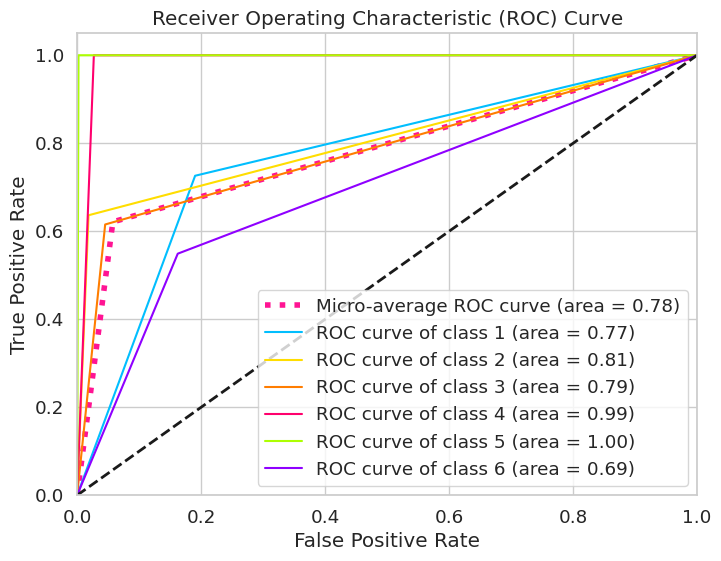

In [244]:
all_predictions_int = np.array(predicted_labels).astype(int)

fpr = dict()
tpr = dict()
roc_auc = dict()

true_labels = np.array(true_labels).astype(int)
for i in range(len(LABEL_COLUMNS)):  # num_classes is the number of classes
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], all_predictions_int[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(true_labels.ravel(), all_predictions_int.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(len(LABEL_COLUMNS)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [246]:
plt.savefig('./roc_curve_weighted_no_dups2_no_pressure_social2.png')

<Figure size 1200x800 with 0 Axes>

In [245]:
with open('./metrics_weighted_all_no_dups2_no_social_pressure2.txt', 'w') as file:
  file.write(report)

In [40]:
with open('./config_weighted_all.txt', 'w') as file:
  file.write('Num Epochs: 3')
  file.write('Bert-base-uncased')
  file.write('Batch size: 32')